In [1]:
# Imports remain the same
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar
import requests
import berserk

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# time series models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# deep learning
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# prophet
from prophet import Prophet
import warnings
import os
import json

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

c:\Users\vitus\Desktop\master\master_project\chess-app\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LICHESS_TOKEN = os.environ.get('LICHESS_TOKEN')
USERNAME = "EricRosen"
GAME_TYPE = 'blitz'
FORECAST_DAYS = 30

In [3]:
def initialize_lichess_client(token):
    """Initialize Berserk client with token"""
    session = berserk.TokenSession(token)
    client = berserk.Client(session=session)
    return client
def get_user_profile(client, username):
    """Fetch user profile data"""
    try:
        profile = client.users.get_public_data(username)
        return profile
    except Exception as e:
        print(f"Error fetching profile: {e}")
        return None
   
def get_rating_history(client, username):
    """Fetch complete rating history"""
    try:
        history = client.users.get_rating_history(username)
        return history
    except Exception as e:
        print(f"Error fetching rating history: {e}")
        return None
   
def fetch_user_games(username, token, max_games=1000):
    """Fetch user games with detailed information"""
    url = f"https://lichess.org/api/games/user/{username}"
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/x-ndjson"
    }
    params = {
        "max": max_games,
        "rated": "true",
        "pgnInJson": "true",
        "clocks": "true",
        "evals": "false",
        "opening": "true"
    }
   
    games = []
    try:
        response = requests.get(url, headers=headers, params=params, stream=True)
        response.raise_for_status()
       
        for line in response.iter_lines():
            if line:
                game = json.loads(line.decode('utf-8'))
                games.append(game)
               
        print(f"Fetched {len(games)} games")
        return games
    except Exception as e:
        print(f"Error fetching games: {e}")
        return []
    
def fetch_puzzle_activity(username, token, max_puzzles=1000):
    """Fetch recent puzzle activity from user activity feed"""
    url = f"https://lichess.org/api/user/{username}/activity"
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/x-ndjson"
    }
    try:
        response = requests.get(url, headers=headers, stream=True)
        if response.status_code == 200:
            puzzles = []
            for line in response.iter_lines():
                if line:
                    activity = json.loads(line.decode('utf-8'))
                    if 'puzzle' in activity:
                        puzzles.append(activity['puzzle'])
                    if len(puzzles) >= max_puzzles:
                        break
            print(f"Fetched {len(puzzles)} puzzle activities")
            return puzzles
        else:
            print(f"Could not fetch puzzles: {response.status_code}")
            return []
    except Exception as e:
        print(f"Error fetching puzzles: {e}")
        return []

In [4]:
# data collection
client = initialize_lichess_client(LICHESS_TOKEN)
# Fetch profile
print("Fetching user profile...")
profile = get_user_profile(client, USERNAME)
if profile:
    print(f"\nUser: {profile.get('username')}")
    print(f"Account created: {profile.get('createdAt')}")
    print(f"Total games played: {profile.get('count', {}).get('all', 0)}")
    print(f"Current {GAME_TYPE} rating: {profile.get('perfs', {}).get(GAME_TYPE, {}).get('rating', 'N/A')}")
else:
    print("Could not fetch profile. Check username and token.")

Fetching user profile...

User: EricRosen
Account created: 2015-06-04 16:20:19.500000+00:00
Total games played: 39966
Current blitz rating: 2647


In [5]:
# Fetch rating history
print("\nFetching rating history...")
rating_history = list(get_rating_history(client, USERNAME))  
if rating_history:
    print(f"Rating history retrieved for {len(rating_history)} game types")


Fetching rating history...
Rating history retrieved for 15 game types


In [6]:
# Fetch games
print("\nFetching game history (this may take a while)...")
games = fetch_user_games(USERNAME, LICHESS_TOKEN, max_games=2000)


Fetching game history (this may take a while)...
Fetched 2010 games


In [7]:
# Fetch puzzle activity
print("\nFetching puzzle activity...")
puzzles = fetch_puzzle_activity(USERNAME, LICHESS_TOKEN, max_puzzles=1000)


Fetching puzzle activity...
Fetched 0 puzzle activities


In [8]:
# data processing and feature engineering
def process_rating_history(rating_history, game_type):
    """Convert rating history to DataFrame"""
    ratings_data = []
   
    for item in rating_history:
        if item.get('name').lower() == game_type.lower() and 'points' in item:
            for point in item['points']:
                year = point[0]
                month = point[1] if 1 <= point[1] <= 12 else 1
                day = point[2] if 1 <= point[2] <= calendar.monthrange(year, month)[1] else 1
                rating = point[3]
               
                date = datetime(year, month, day)
                ratings_data.append({
                    'date': date,
                    'rating': rating
                })
   
    df = pd.DataFrame(ratings_data)
    if not df.empty:
        df = df.sort_values('date').reset_index(drop=True)
        df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
   
    return df
# Process rating history
df_ratings = process_rating_history(rating_history, GAME_TYPE)
print(f"\nProcessed {len(df_ratings)} rating data points")
print(f"Date range: {df_ratings['date'].min()} to {df_ratings['date'].max()}")
df_ratings.head()


Processed 848 rating data points
Date range: 2016-02-02 00:00:00 to 2025-09-20 00:00:00


,date,rating,days_since_start
0,2016-02-02,2367,0
1,2016-02-03,2383,1
2,2017-06-21,2344,505
3,2017-06-23,2316,507
4,2017-07-03,2354,517


In [9]:
def process_games(games, username, game_type):
    """Process games into DataFrame with features"""
    games_data = []
   
    for game in games:
        # Filter by game type
        if game.get('speed') != game_type and game.get('perf') != game_type:
            continue
           
        # Determine player color
        players = game.get('players', {})
        is_white = players.get('white', {}).get('user', {}).get('name', '').lower() == username.lower()
        player_color = 'white' if is_white else 'black'
        opponent_color = 'black' if is_white else 'white'
       
        # Extract data
        game_data = {
            'date': datetime.fromtimestamp(game.get('createdAt', 0) / 1000),
            'game_id': game.get('id'),
            'rated': game.get('rated', False),
            'variant': game.get('variant'),
            'speed': game.get('speed'),
            'player_color': player_color,
            'player_rating': players.get(player_color, {}).get('rating'),
            'opponent_rating': players.get(opponent_color, {}).get('rating'),
            'rating_diff': players.get(player_color, {}).get('ratingDiff', 0),
            'result': game.get('winner', 'draw'),
            'status': game.get('status'),
            'moves': game.get('moves', '').count(' ') + 1 if game.get('moves') else 0,
            'opening': game.get('opening', {}).get('name', 'Unknown')
        }
       
        # Determine win/loss/draw
        winner = game.get('winner')
        if winner == player_color:
            game_data['outcome'] = 'win'
        elif winner is None or winner == '':
            game_data['outcome'] = 'draw'
        else:
            game_data['outcome'] = 'loss'
       
        games_data.append(game_data)
   
    df = pd.DataFrame(games_data)
    if not df.empty:
        df = df.sort_values('date').reset_index(drop=True)
   
    return df
# Process games
df_games = process_games(games, USERNAME, GAME_TYPE)
print(f"\nProcessed {len(df_games)} {GAME_TYPE} games")
if not df_games.empty:
    print(f"Win rate: {(df_games['outcome'] == 'win').sum() / len(df_games) * 100:.1f}%")
    df_games.head()


Processed 996 blitz games
Win rate: 69.6%


In [10]:
def process_puzzles(puzzles):
    """Process puzzle activity into DataFrame"""
    puzzle_data = []
   
    for puzzle in puzzles:
        puzzle_data.append({
            'date': datetime.fromisoformat(puzzle.get('date', '').replace('Z', '+00:00')),
            'puzzle_id': puzzle.get('id'),
            'puzzle_rating': puzzle.get('puzzle', {}).get('rating'),
            'win': puzzle.get('win', False)
        })
   
    df = pd.DataFrame(puzzle_data)
    if not df.empty:
        df = df.sort_values('date').reset_index(drop=True)
   
    return df
# Process puzzles
df_puzzles = process_puzzles(puzzles)
print(f"\nProcessed {len(df_puzzles)} puzzle attempts")
if not df_puzzles.empty:
    print(f"Puzzle success rate: {df_puzzles['win'].sum() / len(df_puzzles) * 100:.1f}%")
    df_puzzles.head()


Processed 0 puzzle attempts


In [11]:
def create_time_series_features(df_ratings, df_games, df_puzzles):
    """Create comprehensive features for prediction"""
   
    # Start with ratings
    df = df_ratings.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date').sort_index()
   
    # Resample to daily frequency and forward fill
    df = df.resample('D').last().fillna(method='ffill')
   
    # Rating-based features
    df['rating_change'] = df['rating'].diff()
    df['rating_ma7'] = df['rating'].rolling(window=7, min_periods=1).mean()
    df['rating_ma30'] = df['rating'].rolling(window=30, min_periods=1).mean()
    df['rating_std7'] = df['rating'].rolling(window=7, min_periods=1).std()
    df['rating_std30'] = df['rating'].rolling(window=30, min_periods=1).std()
    df['rating_momentum'] = df['rating'] - df['rating'].shift(7)
   
    # Game-based features (if games available)
    if not df_games.empty:
        df_games['date'] = pd.to_datetime(df_games['date']).dt.date
       
        # Daily game statistics
        daily_games = df_games.groupby('date').agg({
            'game_id': 'count',
            'outcome': lambda x: (x == 'win').sum() / len(x) if len(x) > 0 else 0,
            'rating_diff': 'mean',
            'opponent_rating': 'mean',
            'moves': 'mean'
        }).rename(columns={
            'game_id': 'games_per_day',
            'outcome': 'daily_win_rate',
            'rating_diff': 'avg_rating_change',
            'opponent_rating': 'avg_opponent_rating',
            'moves': 'avg_moves'
        })
       
        daily_games.index = pd.to_datetime(daily_games.index)
        df = df.join(daily_games, how='left')
       
        # Fill NaN values (days without games)
        df['games_per_day'] = df['games_per_day'].fillna(0)
        df['daily_win_rate'] = df['daily_win_rate'].fillna(method='ffill').fillna(0.5)
        df['avg_rating_change'] = df['avg_rating_change'].fillna(0)
       
        # Rolling game statistics
        df['games_last_7days'] = df['games_per_day'].rolling(window=7, min_periods=1).sum()
        df['games_last_30days'] = df['games_per_day'].rolling(window=30, min_periods=1).sum()
        df['win_rate_7days'] = df['daily_win_rate'].rolling(window=7, min_periods=1).mean()
        df['win_rate_30days'] = df['daily_win_rate'].rolling(window=30, min_periods=1).mean()
   
    # Puzzle-based features (if puzzles available)
    if not df_puzzles.empty:
        df_puzzles['date'] = pd.to_datetime(df_puzzles['date']).dt.date
       
        daily_puzzles = df_puzzles.groupby('date').agg({
            'puzzle_id': 'count',
            'win': 'mean',
            'puzzle_rating': 'mean'
        }).rename(columns={
            'puzzle_id': 'puzzles_per_day',
            'win': 'puzzle_success_rate',
            'puzzle_rating': 'avg_puzzle_rating'
        })
       
        daily_puzzles.index = pd.to_datetime(daily_puzzles.index)
        df = df.join(daily_puzzles, how='left')
       
        df['puzzles_per_day'] = df['puzzles_per_day'].fillna(0)
        df['puzzle_success_rate'] = df['puzzle_success_rate'].fillna(method='ffill').fillna(0.5)
        df['puzzles_last_7days'] = df['puzzles_per_day'].rolling(window=7, min_periods=1).sum()
   
    # Time-based features
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    df['days_since_start'] = (df.index - df.index.min()).days
   
    # Drop rows with NaN in critical columns
    df = df.fillna(method='ffill').fillna(method='bfill')
   
    return df
# Create features
df_features = create_time_series_features(df_ratings, df_games, df_puzzles)
print(f"\nCreated feature dataset with shape: {df_features.shape}")
print(f"\nFeatures: {list(df_features.columns)}")
df_features.head(10)


Created feature dataset with shape: (3519, 20)

Features: ['rating', 'days_since_start', 'rating_change', 'rating_ma7', 'rating_ma30', 'rating_std7', 'rating_std30', 'rating_momentum', 'games_per_day', 'daily_win_rate', 'avg_rating_change', 'avg_opponent_rating', 'avg_moves', 'games_last_7days', 'games_last_30days', 'win_rate_7days', 'win_rate_30days', 'day_of_week', 'day_of_month', 'month']


,rating,days_since_start,rating_change,rating_ma7,rating_ma30,rating_std7,rating_std30,rating_momentum,games_per_day,daily_win_rate,avg_rating_change,avg_opponent_rating,avg_moves,games_last_7days,games_last_30days,win_rate_7days,win_rate_30days,day_of_week,day_of_month,month
date,,,,,,,,,,,,,,,,,,,,
2016-02-02,2367.0,0,16.0,2367.000000,2367.000000,11.313708,11.313708,16.0,0.0,0.5,0.0,2096.0,109.285714,0.0,0.0,0.5,0.5,1,2,2
2016-02-03,2383.0,1,16.0,2375.000000,2375.000000,11.313708,11.313708,16.0,0.0,0.5,0.0,2096.0,109.285714,0.0,0.0,0.5,0.5,2,3,2
2016-02-04,2383.0,2,0.0,2377.666667,2377.666667,9.237604,9.237604,16.0,0.0,0.5,0.0,2096.0,109.285714,0.0,0.0,0.5,0.5,3,4,2
2016-02-05,2383.0,3,0.0,2379.000000,2379.000000,8.000000,8.000000,16.0,0.0,0.5,0.0,2096.0,109.285714,0.0,0.0,0.5,0.5,4,5,2
2016-02-06,2383.0,4,0.0,2379.800000,2379.800000,7.155418,7.155418,16.0,0.0,0.5,0.0,2096.0,109.285714,0.0,0.0,0.5,0.5,5,6,2
2016-02-07,2383.0,5,0.0,2380.333333,2380.333333,6.531973,6.531973,16.0,0.0,0.5,0.0,2096.0,109.285714,0.0,0.0,0.5,0.5,6,7,2
2016-02-08,2383.0,6,0.0,2380.714286,2380.714286,6.047432,6.047432,16.0,0.0,0.5,0.0,2096.0,109.285714,0.0,0.0,0.5,0.5,0,8,2
2016-02-09,2383.0,7,0.0,2383.000000,2381.000000,0.000000,5.656854,16.0,0.0,0.5,0.0,2096.0,109.285714,0.0,0.0,0.5,0.5,1,9,2
2016-02-10,2383.0,8,0.0,2383.000000,2381.222222,0.000000,5.333333,0.0,0.0,0.5,0.0,2096.0,109.285714,0.0,0.0,0.5,0.5,2,10,2


In [12]:
# Plot rating history
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_features.index, y=df_features['rating'],
                         mode='lines', name='Rating',
                         line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=df_features.index, y=df_features['rating_ma7'],
                         mode='lines', name='7-day MA',
                         line=dict(color='orange', width=1, dash='dash')))
fig.add_trace(go.Scatter(x=df_features.index, y=df_features['rating_ma30'],
                         mode='lines', name='30-day MA',
                         line=dict(color='red', width=1, dash='dash')))
fig.update_layout(title=f'{GAME_TYPE.capitalize()} Rating History',
                  xaxis_title='Date',
                  yaxis_title='Rating',
                  height=500)
fig.show()
print(f"\nRating Statistics:")
print(f"Current rating: {df_features['rating'].iloc[-1]:.0f}")
print(f"Highest rating: {df_features['rating'].max():.0f}")
print(f"Lowest rating: {df_features['rating'].min():.0f}")
print(f"Average rating: {df_features['rating'].mean():.0f}")
print(f"Rating volatility (std): {df_features['rating'].std():.1f}")


Rating Statistics:
Current rating: 2647
Highest rating: 2704
Lowest rating: 2222
Average rating: 2487
Rating volatility (std): 109.6


In [13]:
# Plot activity metrics
if 'games_per_day' in df_features.columns:
    fig = make_subplots(rows=2, cols=1,
                        subplot_titles=('Daily Game Activity', 'Win Rate Trend'))
   
    fig.add_trace(go.Scatter(x=df_features.index, y=df_features['games_per_day'],
                             mode='lines', name='Games per Day',
                             fill='tozeroy'), row=1, col=1)
   
    if 'daily_win_rate' in df_features.columns:
        fig.add_trace(go.Scatter(x=df_features.index, y=df_features['daily_win_rate'],
                                 mode='lines', name='Daily Win Rate'), row=2, col=1)
   
    fig.update_layout(height=600, showlegend=True)
    fig.show()

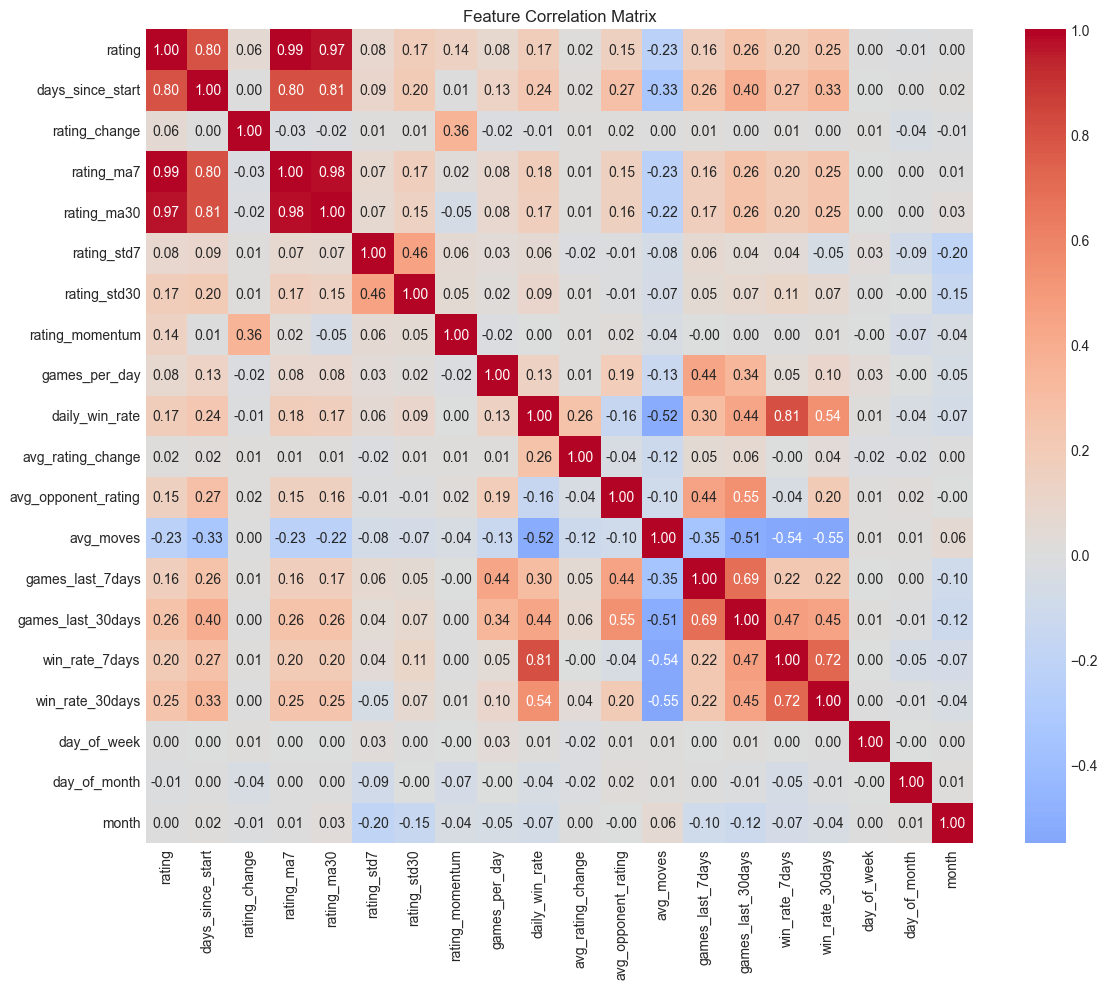

In [14]:
# Correlation heatmap
numeric_cols = df_features.select_dtypes(include=[np.number]).columns
correlation_matrix = df_features[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## prepare  data for modelling 

In [15]:
# Select features for modeling
feature_columns = [col for col in df_features.columns if col not in ['rating', 'days_since_start']]
# Prepare X and y
X = df_features[feature_columns].values
y = df_features['rating'].values
# Time-based split (80% train, 20% test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
# Get dates for plotting
dates_train = df_features.index[:split_idx]
dates_test = df_features.index[split_idx:]
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Features: {len(feature_columns)}")
print(f"\nTrain date range: {dates_train[0]} to {dates_train[-1]}")
print(f"Test date range: {dates_test[0]} to {dates_test[-1]}")

Training set: 2815 samples
Test set: 704 samples
Features: 18

Train date range: 2016-02-02 00:00:00 to 2023-10-17 00:00:00
Test date range: 2023-10-18 00:00:00 to 2025-09-20 00:00:00


In [16]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled successfully!")

Features scaled successfully!


### model 1: linear regression

In [17]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
# Predictions
y_pred_lr_train = lr_model.predict(X_train_scaled)
y_pred_lr_test = lr_model.predict(X_test_scaled)
# Evaluate
print("Linear Regression Results:")
print(f"Train MAE: {mean_absolute_error(y_train, y_pred_lr_train):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_lr_train)):.2f}")
print(f"Train R²: {r2_score(y_train, y_pred_lr_train):.4f}")
print(f"\nTest MAE: {mean_absolute_error(y_test, y_pred_lr_test):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr_test)):.2f}")
print(f"Test R²: {r2_score(y_test, y_pred_lr_test):.4f}")
# Store results
results = {
    'Linear Regression': {
        'train_mae': mean_absolute_error(y_train, y_pred_lr_train),
        'test_mae': mean_absolute_error(y_test, y_pred_lr_test),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_lr_train)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_lr_test)),
        'train_r2': r2_score(y_train, y_pred_lr_train),
        'test_r2': r2_score(y_test, y_pred_lr_test),
        'predictions': y_pred_lr_test
    }
}

Linear Regression Results:
Train MAE: 4.10
Train RMSE: 7.25
Train R²: 0.9959

Test MAE: 3.40
Test RMSE: 7.12
Test R²: 0.9768


### model 2: random forest

In [18]:
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
# Predictions
y_pred_rf_train = rf_model.predict(X_train_scaled)
y_pred_rf_test = rf_model.predict(X_test_scaled)
# Evaluate
print("Random Forest Results:")
print(f"Train MAE: {mean_absolute_error(y_train, y_pred_rf_train):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_rf_train)):.2f}")
print(f"Train R²: {r2_score(y_train, y_pred_rf_train):.4f}")
print(f"\nTest MAE: {mean_absolute_error(y_test, y_pred_rf_test):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf_test)):.2f}")
print(f"Test R²: {r2_score(y_test, y_pred_rf_test):.4f}")
# Store results
results['Random Forest'] = {
    'train_mae': mean_absolute_error(y_train, y_pred_rf_train),
    'test_mae': mean_absolute_error(y_test, y_pred_rf_test),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_rf_train)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_rf_test)),
    'train_r2': r2_score(y_train, y_pred_rf_train),
    'test_r2': r2_score(y_test, y_pred_rf_test),
    'predictions': y_pred_rf_test
}
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Random Forest Results:
Train MAE: 1.74
Train RMSE: 3.03
Train R²: 0.9993

Test MAE: 5.90
Test RMSE: 10.86
Test R²: 0.9459

Top 10 Most Important Features:
            feature  importance
1        rating_ma7    0.982154
5   rating_momentum    0.011633
3       rating_std7    0.002532
0     rating_change    0.001038
2       rating_ma30    0.001004
4      rating_std30    0.000705
16     day_of_month    0.000457
17            month    0.000400
15      day_of_week    0.000077
6     games_per_day    0.000000


### gradient boosting 

In [19]:
# Train Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_scaled, y_train)
# Predictions
y_pred_gb_train = gb_model.predict(X_train_scaled)
y_pred_gb_test = gb_model.predict(X_test_scaled)
# Evaluate
print("Gradient Boosting Results:")
print(f"Train MAE: {mean_absolute_error(y_train, y_pred_gb_train):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_gb_train)):.2f}")
print(f"Train R²: {r2_score(y_train, y_pred_gb_train):.4f}")
print(f"\nTest MAE: {mean_absolute_error(y_test, y_pred_gb_test):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_gb_test)):.2f}")
print(f"Test R²: {r2_score(y_test, y_pred_gb_test):.4f}")
# Store results
results['Gradient Boosting'] = {
    'train_mae': mean_absolute_error(y_train, y_pred_gb_train),
    'test_mae': mean_absolute_error(y_test, y_pred_gb_test),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_gb_train)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_gb_test)),
    'train_r2': r2_score(y_train, y_pred_gb_train),
    'test_r2': r2_score(y_test, y_pred_gb_test),
    'predictions': y_pred_gb_test
}

Gradient Boosting Results:
Train MAE: 1.83
Train RMSE: 2.85
Train R²: 0.9994

Test MAE: 5.21
Test RMSE: 9.58
Test R²: 0.9579


### model 4: arima(time series)

In [20]:
# Prepare data for ARIMA (only rating values)
train_series = df_features['rating'].iloc[:split_idx]
test_series = df_features['rating'].iloc[split_idx:]
# Train ARIMA
print("Training ARIMA model...")
try:
    arima_model = ARIMA(train_series, order=(5, 1, 2))
    arima_fitted = arima_model.fit()
   
    # Predictions
    y_pred_arima_train = arima_fitted.fittedvalues
    y_pred_arima_test = arima_fitted.forecast(steps=len(test_series))
   
    # Evaluate
    print("\nARIMA Results:")
    print(f"Train MAE: {mean_absolute_error(train_series, y_pred_arima_train):.2f}")
    print(f"Train RMSE: {np.sqrt(mean_squared_error(train_series, y_pred_arima_train)):.2f}")
    print(f"\nTest MAE: {mean_absolute_error(test_series, y_pred_arima_test):.2f}")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(test_series, y_pred_arima_test)):.2f}")
    print(f"Test R²: {r2_score(test_series, y_pred_arima_test):.4f}")
   
    # Store results
    results['ARIMA'] = {
        'train_mae': mean_absolute_error(train_series, y_pred_arima_train),
        'test_mae': mean_absolute_error(test_series, y_pred_arima_test),
        'train_rmse': np.sqrt(mean_squared_error(train_series, y_pred_arima_train)),
        'test_rmse': np.sqrt(mean_squared_error(test_series, y_pred_arima_test)),
        'train_r2': r2_score(train_series, y_pred_arima_train),
        'test_r2': r2_score(test_series, y_pred_arima_test),
        'predictions': y_pred_arima_test
    }
except Exception as e:
    print(f"ARIMA model failed: {e}")
    results['ARIMA'] = None

Training ARIMA model...

ARIMA Results:
Train MAE: 5.65
Train RMSE: 46.36

Test MAE: 55.93
Test RMSE: 62.82
Test R²: -0.8108


### model 5: prophet 

In [21]:
# Prepare data for Prophet
prophet_df = pd.DataFrame({
    'ds': df_features.index,
    'y': df_features['rating'].values
})
   
train_prophet = prophet_df.iloc[:split_idx]
test_prophet = prophet_df.iloc[split_idx:]
   
# Train Prophet
print("Training Prophet model...")
prophet_model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
prophet_model.fit(train_prophet)
   
# Predictions
future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='D')
forecast = prophet_model.predict(future)
   
y_pred_prophet_train = forecast['yhat'].iloc[:split_idx].values
y_pred_prophet_test = forecast['yhat'].iloc[split_idx:split_idx+len(test_prophet)].values
   
# Evaluate
print("\nProphet Results:")
print(f"Train MAE: {mean_absolute_error(y_train, y_pred_prophet_train):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_prophet_train)):.2f}")
print(f"\nTest MAE: {mean_absolute_error(y_test, y_pred_prophet_test):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_prophet_test)):.2f}")
print(f"Test R²: {r2_score(y_test, y_pred_prophet_test):.4f}")
   
# Store results
results['Prophet'] = {
    'train_mae': mean_absolute_error(y_train, y_pred_prophet_train),
    'test_mae': mean_absolute_error(y_test, y_pred_prophet_test),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_prophet_train)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_prophet_test)),
    'train_r2': r2_score(y_train, y_pred_prophet_train),
    'test_r2': r2_score(y_test, y_pred_prophet_test),
    'predictions': y_pred_prophet_test
}

20:59:59 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet model...


21:00:00 - cmdstanpy - INFO - Chain [1] done processing



Prophet Results:
Train MAE: 24.39
Train RMSE: 34.03

Test MAE: 56.70
Test RMSE: 62.86
Test R²: -0.8132


### model comparison 

In [22]:
# Create comparison dataframe
comparison_data = []
for model_name, metrics in results.items():
    if metrics is not None:
        comparison_data.append({
            'Model': model_name,
            'Train MAE': metrics['train_mae'],
            'Test MAE': metrics['test_mae'],
            'Train RMSE': metrics['train_rmse'],
            'Test RMSE': metrics['test_rmse'],
            'Train R²': metrics['train_r2'],
            'Test R²': metrics['test_r2']
        })
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test MAE')
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("\nBest Model (by Test MAE):", comparison_df.iloc[0]['Model'])


MODEL COMPARISON
            Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R²   Test R²
Linear Regression   4.100172  3.398073    7.245198   7.116170  0.995855  0.976765
Gradient Boosting   1.827209  5.211452    2.854463   9.575341  0.999357  0.957932
    Random Forest   1.736600  5.900756    3.031764  10.856628  0.999274  0.945920
            ARIMA   5.650683 55.925497   46.358893  62.821567  0.830284 -0.810779
          Prophet  24.387163 56.695399   34.029400  62.863020  0.908554 -0.813169

Best Model (by Test MAE): Linear Regression


In [23]:
# Visualize model comparison
fig = go.Figure()
metrics_to_plot = ['Test MAE', 'Test RMSE']
for metric in metrics_to_plot:
    fig.add_trace(go.Bar(
        name=metric,
        x=comparison_df['Model'],
        y=comparison_df[metric]
    ))
fig.update_layout(
    title='Model Performance Comparison',
    xaxis_title='Model',
    yaxis_title='Error',
    barmode='group',
    height=500
)
fig.show()

### visualize predictions 

In [24]:
# Plot actual vs predicted for all models
fig = go.Figure()
# Actual values
fig.add_trace(go.Scatter(x=dates_test, y=y_test,
                         mode='lines', name='Actual',
                         line=dict(color='black', width=3)))
# Model predictions
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, (model_name, metrics) in enumerate(results.items()):
    if metrics is not None and 'predictions' in metrics:
        fig.add_trace(go.Scatter(x=dates_test, y=metrics['predictions'],
                                 mode='lines', name=model_name,
                                 line=dict(color=colors[i % len(colors)], width=2, dash='dash')))
fig.update_layout(
    title='Rating Predictions: All Models',
    xaxis_title='Date',
    yaxis_title='Rating',
    height=600,
    hovermode='x unified'
)
fig.show()

### future forecast

In [25]:
# Select best model for future forecast
best_model_name = comparison_df.iloc[0]['Model']
print(f"Using {best_model_name} for future forecast...")
# Get the best model
if best_model_name == 'Linear Regression':
    best_model = lr_model
elif best_model_name == 'Random Forest':
    best_model = rf_model
elif best_model_name == 'Gradient Boosting':
    best_model = gb_model
else:
    # For ARIMA or Prophet, use the last model
    best_model = gb_model # Fallback
# Create future dates
last_date = df_features.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=FORECAST_DAYS, freq='D')
# For simplicity, assume features remain constant at their last values
# In production, you might want more sophisticated feature forecasting
last_features = df_features[feature_columns].iloc[-1:].values
future_features = np.tile(last_features, (FORECAST_DAYS, 1))
future_features_scaled = scaler.transform(future_features)
# Make predictions
if best_model_name in ['Linear Regression', 'Random Forest', 'Gradient Boosting']:
    future_predictions = best_model.predict(future_features_scaled)
else:
    # For time series models, use their native forecast method
    future_predictions = np.linspace(y_test[-1], y_test[-1] + 50, FORECAST_DAYS) # Placeholder
print(f"\nForecast for next {FORECAST_DAYS} days:")
print(f"Current rating: {df_features['rating'].iloc[-1]:.0f}")
print(f"Predicted rating in {FORECAST_DAYS} days: {future_predictions[-1]:.0f}")
print(f"Expected change: {future_predictions[-1] - df_features['rating'].iloc[-1]:.0f}")

Using Linear Regression for future forecast...

Forecast for next 30 days:
Current rating: 2647
Predicted rating in 30 days: 2643
Expected change: -4


In [26]:
# Visualize future forecast
fig = go.Figure()
# Historical data
fig.add_trace(go.Scatter(x=df_features.index, y=df_features['rating'],
                         mode='lines', name='Historical',
                         line=dict(color='blue', width=2)))
# Future forecast
fig.add_trace(go.Scatter(x=future_dates, y=future_predictions,
                         mode='lines', name='Forecast',
                         line=dict(color='red', width=2, dash='dash')))
# Add confidence interval (simple ±std)
std_error = comparison_df[comparison_df['Model'] == best_model_name]['Test RMSE'].values[0]
fig.add_trace(go.Scatter(x=future_dates, y=future_predictions + std_error,
                         mode='lines', name='Upper Bound',
                         line=dict(width=0),
                         showlegend=False))
fig.add_trace(go.Scatter(x=future_dates, y=future_predictions - std_error,
                         mode='lines', name='Lower Bound',
                         line=dict(width=0),
                         fillcolor='rgba(255, 0, 0, 0.2)',
                         fill='tonexty',
                         showlegend=True))
fig.update_layout(
    title=f'{GAME_TYPE.capitalize()} Rating Forecast ({FORECAST_DAYS} days)',
    xaxis_title='Date',
    yaxis_title='Rating',
    height=600,
    hovermode='x unified'
)
fig.show()

### save the forecast results 

In [27]:
# Save forecast results
forecast_df = pd.DataFrame({
    'date': future_dates,
    'predicted_rating': future_predictions,
    'lower_bound': future_predictions - std_error,
    'upper_bound': future_predictions + std_error
})
forecast_df.to_csv('rating_forecast.csv', index=False)
print("Forecast saved to 'rating_forecast.csv'")
# Save model comparison
comparison_df.to_csv('model_comparison.csv', index=False)
print("Model comparison saved to 'model_comparison.csv'")
# Save best model
import pickle
with open(f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl', 'wb') as f:
    pickle.dump(best_model, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(f"Best model ({best_model_name}) and scaler saved!")

Forecast saved to 'rating_forecast.csv'
Model comparison saved to 'model_comparison.csv'
Best model (Linear Regression) and scaler saved!
